# Online Data Science Courses. Preprocessing pipeline

## Data Science courses scraped from the popular online educational platforms


### Context

Nowadays, online educational platforms provide a vast amount of online courses. For self-learning beginners in Data Science, sometimes it's hard to choose an online course to start. This data was collected with the intent to answer common questions when choosing a new study.


### Acknowledgements

Data was collected via web scraping from popular online platforms: [Coursera](https://www.coursera.org), [Stepik](https://stepik.org), [Udemy](https://www.udemy.com), [edX](https://www.edx.org), [Pluralsight](https://www.pluralsight.com) and [Alison](https://alison.com). From each platform were queried courses only related to the "Data Science" topic. The original author of the [image thumbnail](https://unsplash.com/photos/Im7lZjxeLhg) is [Ales Nesetril](https://unsplash.com/@alesnesetril).


### Inspiration

The primary intent behind collecting courses data is to discover which online platform provides the highest educational quality. Also, further analysis should reveal answers like "Does a paid course provide higher quality than a free one?" or "Which platform is the most suitable for beginners?".



## Environment preparation

Creating Spark session

In [ ]:
!spark-shell --version 2>&1 | sed -n '8,15'p

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.1.1
      /_/
                        
Using Scala version 2.12.10, OpenJDK 64-Bit Server VM, 11.0.11


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import *

spark = SparkSession.builder \
    .appName("Online Data Science Courses")\
    .master("local[*]")\
    .config("spark.driver.memory","40G")\
    .config("spark.driver.maxResultSize", "0")\
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .getOrCreate()

spark

## Coursera pipeline preprocessing

In [ ]:
schema = StructType()\
            .add("title", StringType(), True)\
            .add("description", StringType(), True)\
            .add("authors", ArrayType(StringType()), True)\
            .add("rating", DoubleType(), True)\
            .add("votes_count", StringType(), True)\
            .add("students_count", StringType(), True)\
            .add("level", StringType(), True)\
            .add("duration", StringType(), True)\
            .add("platform", StringType(), True)\
            .add("free", BooleanType(), True)

coursera_dataset = spark.read.format("json")\
            .schema(schema)\
            .load("../input/coursera.json")

coursera_dataset.toPandas().head()

,title,description,authors,rating,votes_count,students_count,level,duration,platform,free
0,Google Data Analytics,This is your path to a career in data analytic...,[Google],4.8,"(28,287)",490k,Beginner,Approximately 6 months to complete\nSuggested ...,Coursera,False
1,IBM Data Science,Kickstart your career in data science & ML. Bu...,[IBM],4.6,"(82,130)",950k,Beginner,None,Coursera,False
2,IBM Data Analyst,Unlock your potential in data analytics. Build...,[IBM],4.6,"(41,405)",630k,Beginner,None,Coursera,False
3,Introduction to Data Science,Launch your career in data science. Gain found...,[IBM],4.6,"(61,482)",620k,Beginner,None,Coursera,False
4,Data Science Fundamentals with Python and SQL,Build the Foundation for your Data Science car...,[IBM],4.6,"(40,947)",520k,Beginner,Approximately 6 months to complete\nSuggested ...,Coursera,False


In [ ]:
coursera_dataset.toPandas().count()

title             1000
description        107
authors           1000
rating             825
votes_count        825
students_count     681
level             1000
duration           666
platform          1000
free              1000
dtype: int64

In [ ]:
import re


re_digits_in_words = re.compile(r'\b(\w)*(\d)(\w)*\b')
re_redundant_spaces = re.compile(r'[ ]+')


def preprocessing_text_pipeline(text: str) -> str:
    if text is None:
        return None

    steps = [
        lambda text: text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' '),
        # Remove words that contain digits
        lambda text: re_digits_in_words.sub('', text),
        # Remove redundant spaces between each word
        lambda text: re_redundant_spaces.sub(' ', text),
        # Strip string
        lambda text: text.strip()
    ]
    
    for step in steps:
        text = step(text)
        
    return text


def normalize_student_count(student_count: str) -> int:
    if student_count is None:
        return None
    
    base_count = float(student_count[:-1])
    multiplyer_count = student_count[-1]
    
    if multiplyer_count == 'm':
        return int(base_count * 1000000)
    elif multiplyer_count == 'k':
        return int(base_count * 1000)
    else:
        return int(base_count)

def normalize_votes_count(votes_count: str) -> int:
    if votes_count is None:
        return None
    
    valid_votes_count = votes_count[1:-1]
    valid_votes_count = valid_votes_count.replace(',', '')
    return int(valid_votes_count)


def normalize_authors(authors: list) -> str:
    if authors is None or len(authors) == 0:
        return None
    
    return authors[0]


def normalize_duration(duration: str) -> float:
    if duration is None or "Approx" not in duration:
        return None
    
    weeks_and_hours = re.findall(r'\d+', duration)
    
    if len(weeks_and_hours) > 1:
        return int(weeks_and_hours[0]) * 4 * int(weeks_and_hours[1]) * 1.0
    else:
        return int(weeks_and_hours[0]) * 1.0


preprocessing_text_pipeline_udf = udf(lambda x: preprocessing_text_pipeline(x), StringType())
normalize_authors_udf = udf(lambda x: normalize_authors(x), StringType())
normalize_student_count_udf = udf(lambda x: normalize_student_count(x), IntegerType())
normalize_votes_count_udf = udf(lambda x: normalize_votes_count(x), IntegerType())
normalize_duration_udf = udf(lambda x: normalize_duration(x), DoubleType())
    
coursera_dataset_normalize = coursera_dataset.select(
    preprocessing_text_pipeline_udf(col("title")).alias("title"),
    normalize_authors_udf(col("authors")).alias("author"),
    col("rating"),
    normalize_votes_count_udf(col("votes_count")).alias("votes_count"),
    normalize_student_count_udf(col("students_count")).alias("students_count"),
    col("level"),
    normalize_duration_udf(col("duration")).alias("duration"),
    col("platform"),
    col("free")
)

coursera_dataset_normalize.toPandas().head()

,title,author,rating,votes_count,students_count,level,duration,platform,free
0,Google Data Analytics,Google,4.8,28287.0,490000.0,Beginner,240.0,Coursera,False
1,IBM Data Science,IBM,4.6,82130.0,950000.0,Beginner,NaN,Coursera,False
2,IBM Data Analyst,IBM,4.6,41405.0,630000.0,Beginner,NaN,Coursera,False
3,Introduction to Data Science,IBM,4.6,61482.0,620000.0,Beginner,NaN,Coursera,False
4,Data Science Fundamentals with Python and SQL,IBM,4.6,40947.0,520000.0,Beginner,72.0,Coursera,False


array([[<AxesSubplot:title={'center':'duration'}>]], dtype=object)

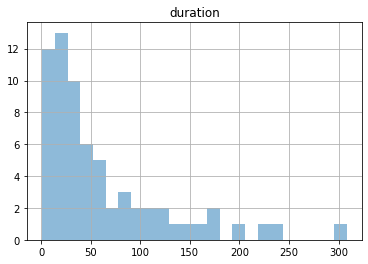

In [ ]:
coursera_dataset_normalize.select(col("duration")).distinct().toPandas().hist(bins=24, alpha=0.5)

## Stepik pipeline preprocessing

In [ ]:
schema = StructType()\
            .add("title", StringType(), True)\
            .add("authors", ArrayType(StringType()), True)\
            .add("rating", DoubleType(), True)\
            .add("votes_count", DoubleType(), True)\
            .add("students_count", IntegerType(), True)\
            .add("level", StringType(), True)\
            .add("duration", DoubleType(), True)\
            .add("platform", StringType(), True)\
            .add("free", BooleanType(), True)

stepik_dataset = spark.read.format("json")\
            .schema(schema)\
            .load("../input/stepik.json")

stepik_dataset.toPandas().head()

,title,authors,rating,votes_count,students_count,level,duration,platform,free
0,Introduction to Statistics,[Bioinformatics Institute],4.6,56.0,38386,Beginner,10.0,Stepik,True
1,Principles of Research and Statistics Design i...,[Dina Sarsembaeva],4.8,31.0,2891,Intermediate,1.0,Stepik,True
2,Data visualization and the basics of working i...,[Anastasia Kuznetsova],5.0,6.0,113,Intermediate,NaN,Stepik,False
3,Probability Theory,[Alexey Karachev],4.9,14.0,1462,Beginner,NaN,Stepik,True
4,Analyzing data in R,[Bioinformatics Institute],4.9,397.0,40584,Beginner,15.5,Stepik,True


In [ ]:
stepik_dataset.toPandas().count()

title             12
authors           12
rating            10
votes_count       10
students_count    12
level             12
duration           6
platform          12
free              12
dtype: int64

In [ ]:
stepik_dataset_normalize = stepik_dataset.select(
    preprocessing_text_pipeline_udf(col("title")).alias("title"),
    normalize_authors_udf(col("authors")).alias("author"),
    col("rating"),
    col("votes_count"),
    col("students_count"),
    col("level"),
    col("duration"),
    col("platform"),
    col("free")
)

stepik_dataset_normalize.toPandas().head()

,title,author,rating,votes_count,students_count,level,duration,platform,free
0,Introduction to Statistics,Bioinformatics Institute,4.6,56.0,38386,Beginner,10.0,Stepik,True
1,Principles of Research and Statistics Design i...,Dina Sarsembaeva,4.8,31.0,2891,Intermediate,1.0,Stepik,True
2,Data visualization and the basics of working i...,Anastasia Kuznetsova,5.0,6.0,113,Intermediate,NaN,Stepik,False
3,Probability Theory,Alexey Karachev,4.9,14.0,1462,Beginner,NaN,Stepik,True
4,Analyzing data in R,Bioinformatics Institute,4.9,397.0,40584,Beginner,15.5,Stepik,True


## Edx pipeline preprocessing

In [ ]:
schema = StructType()\
            .add("title", StringType(), True)\
            .add("description", StringType(), True)\
            .add("authors", ArrayType(StringType()), True)\
            .add("rating", DoubleType(), True)\
            .add("votes_count", IntegerType(), True)\
            .add("students_count", StringType(), True)\
            .add("level", StringType(), True)\
            .add("duration", StringType(), True)\
            .add("platform", StringType(), True)\
            .add("free", BooleanType(), True)

edx_dataset = spark.read.format("json")\
            .schema(schema)\
            .load("../input/edx.json")

edx_dataset.toPandas().head()

,title,description,authors,rating,votes_count,students_count,level,duration,platform,free
0,Python Basics for Data Science,This Python course provides a beginner-friendl...,[Institution: IBM],NaN,NaN,"424,785 already enrolled! After a course sessi...",Level: Introductory,Estimated 3 weeks\n4–10 hours per week,edX,True
1,Bridging Differences,Learn research-based strategies for better rel...,[Institution: BerkeleyX],NaN,NaN,None,Level: Introductory,Estimated 10 weeks\n3–4 hours per week,edX,True
2,Data for Better Lives: A New Social Contract,"With this course, explore the 2021 World Devel...",[Institution: WBGx],NaN,NaN,Future dates to be announced,Level: Introductory,Estimated 6 weeks\n3–5 hours per week,edX,True
3,Leadership: Creating Public Value,"In Leadership: Creating Public Value, learn ho...",[Institution: HarvardX],NaN,NaN,None,Level: Introductory,Estimated 7 weeks\n2–3 hours per week,edX,True
4,Python for Data Science,"Learn to use powerful, open-source, Python too...",[Institution: UCSanDiegoX],NaN,NaN,"293,042 already enrolled! After a course sessi...",Level: Advanced,Estimated 10 weeks\n8–10 hours per week,edX,True


In [ ]:
edx_dataset.toPandas().count()

title             329
description       295
authors           329
rating              0
votes_count         0
students_count    203
level             329
duration          329
platform          329
free              329
dtype: int64

In [ ]:
import numpy as np


def normalize_authors(authors: list) -> str:
    if authors is None or len(authors) == 0:
        return None
    
    return authors[0].replace("Institutions: ", "").replace("Institution: ", "")


def normalize_students_count(students_count: str) -> int:
    if students_count is None:
        return None
    
    students = re.findall(r'\d+', students_count)

    if len(students) == 0:
        return None
    
    return int("".join(students))


def normalize_level(level: str) -> str:
    level = level.replace("Level: ", "")
    
    if level == "Introductory":
        return "Beginner"
    else:
        return level
    
    
def normalize_duration(duration: str) -> float:
    if '\n' in duration:    
        weeks_and_hours = duration.split('\n')
        weeks, hours = weeks_and_hours[0], weeks_and_hours[1]
        
        weeks_norm = int(re.findall(r'\d+', weeks)[0])
        hours_norm = np.sum([float(int(n)) for n in re.findall(r'\d+', hours)]) / 2.0
        
        return weeks_norm * 4.0  
    else:
        return int(re.findall(r'\d+', duration)[0]) * 1.0
    

normalize_authors_udf = udf(lambda x: normalize_authors(x), StringType())
normalize_level_udf = udf(lambda x: normalize_level(x), StringType())
normalize_students_count_udf = udf(lambda x: normalize_students_count(x), IntegerType())
normalize_duration_udf = udf(lambda x: normalize_duration(x), DoubleType())

edx_dataset_normalize = edx_dataset.select(
    preprocessing_text_pipeline_udf(col("title")).alias("title"),
    normalize_authors_udf(col("authors")).alias("author"),
    col("rating"),
    col("votes_count"),
    normalize_students_count_udf(col("students_count")).alias("students_count"),
    normalize_level_udf(col("level")).alias("level"),
    normalize_duration_udf(col("duration")).alias("duration"),
    col("platform"),
    col("free")
)

edx_dataset_normalize.toPandas().head()

,title,author,rating,votes_count,students_count,level,duration,platform,free
0,Python Basics for Data Science,IBM,NaN,NaN,424785.0,Beginner,12.0,edX,True
1,Bridging Differences,BerkeleyX,NaN,NaN,NaN,Beginner,40.0,edX,True
2,Data for Better Lives: A New Social Contract,WBGx,NaN,NaN,NaN,Beginner,24.0,edX,True
3,Leadership: Creating Public Value,HarvardX,NaN,NaN,NaN,Beginner,28.0,edX,True
4,Python for Data Science,UCSanDiegoX,NaN,NaN,293042.0,Advanced,40.0,edX,True


In [ ]:
edx_dataset_normalize.select(col("duration")).distinct().collect()

[Row(duration=8.0),
 Row(duration=64.0),
 Row(duration=96.0),
 Row(duration=80.0),
 Row(duration=36.0),
 Row(duration=4.0),
 Row(duration=140.0),
 Row(duration=56.0),
 Row(duration=72.0),
 Row(duration=48.0),
 Row(duration=60.0),
 Row(duration=28.0),
 Row(duration=40.0),
 Row(duration=20.0),
 Row(duration=52.0),
 Row(duration=32.0),
 Row(duration=24.0),
 Row(duration=16.0),
 Row(duration=12.0)]

## Pluralsight pipeline preprocessing

In [ ]:
schema = StructType()\
            .add("title", StringType(), True)\
            .add("description", StringType(), True)\
            .add("authors", ArrayType(StringType()), True)\
            .add("rating", StringType(), True)\
            .add("votes_count", StringType(), True)\
            .add("students_count", StringType(), True)\
            .add("level", StringType(), True)\
            .add("duration", StringType(), True)\
            .add("platform", StringType(), True)\
            .add("free", BooleanType(), True)

pluralsight_dataset = spark.read.format("json")\
            .schema(schema)\
            .load("../input/pluralsight.json")

pluralsight_dataset.toPandas().head()

,title,description,authors,rating,votes_count,students_count,level,duration,platform,free
0,Data Science: The Big Picture,Data science is the practice of transforming r...,[Matthew Renze],fa fa-star;fa fa-star;fa fa-star;fa fa-star;fa...,(825),None,Beginner,1h 9m,Pluralsight,False
1,Analyzing Business Requirements for Data Science,This course takes you through the complete lif...,[Paul Foran],fa fa-star;fa fa-star;fa fa-star;fa fa-star-ha...,(54),None,Beginner,50m,Pluralsight,False
2,Boost Data Science Productivity with PyCharm,PyCharm is an incredible Python integrated dev...,[Dan Tofan],fa fa-star;fa fa-star;fa fa-star;fa fa-star;fa...,(25),None,Intermediate,2h 33m,Pluralsight,False
3,Data Management and Preparation Using R,Data management and data preparation is a very...,[Martin Burger],fa fa-star;fa fa-star;fa fa-star;fa fa-star;fa...,(25),None,Beginner,1h 59m,Pluralsight,False
4,Cleaning Data: Python Data Playbook,Cleaning the dataset is an essential part of a...,[Chris Achard],fa fa-star;fa fa-star;fa fa-star;fa fa-star;fa...,(56),None,Beginner,1h 8m,Pluralsight,False


In [ ]:
def normalize_authors(authors: list) -> str:
    if authors is None or len(authors) == 0:
        return None
    
    return authors[0]


def normalize_votes_count(votes_count: str) -> int:
    if votes_count is None:
        return None
    
    valid_votes_count = votes_count[1:-1]
    valid_votes_count = valid_votes_count.replace(',', '')
    return int(valid_votes_count)


def normalize_rating(rating: str) -> float:
    if len(rating) == 0:
        return None
    else:
        fa_stars = rating.split(';')
        total_rating = 0.0
        
        for fa_star in fa_stars:
            if fa_star == 'fa fa-star':
                total_rating += 1.0
            elif fa_star == 'fa fa-star-half-o':
                total_rating += 0.5
        
        return total_rating
    
    
def normalize_duration(duration: str) -> float:
    decimals = re.findall(r'\d+', duration)
    
    if len(decimals) == 2:
        final_decimal = float(np.round(float(int(decimals[0])) + float(int(decimals[1])) / 60.0, decimals=1))
        return final_decimal if final_decimal != 0.0 else 0.1
    elif len(decimals) == 1:
        final_decimal = float(np.round(float(int(decimals[0])) / 60.0, decimals=1))
        return final_decimal if final_decimal != 0.0 else 0.1
    else:
        return None


normalize_authors_udf = udf(lambda x: normalize_authors(x), StringType())
normalize_votes_count_udf = udf(lambda x: normalize_votes_count(x), IntegerType())
normalize_rating_udf = udf(lambda x: normalize_rating(x), DoubleType())
normalize_duration_udf = udf(lambda x: normalize_duration(x), DoubleType())


pluralsight_dataset_normalize = pluralsight_dataset.select(
    preprocessing_text_pipeline_udf(col("title")).alias("title"),
    normalize_authors_udf(col("authors")).alias("author"),
    normalize_rating_udf(col("rating")).alias("rating"),
    normalize_votes_count_udf(col("votes_count")).alias("votes_count"),
    col("students_count"),
    col("level"),
    normalize_duration_udf(col("duration")).alias("duration"),
    col("platform"),
    col("free")
)

pluralsight_dataset_normalize.toPandas().head()

,title,author,rating,votes_count,students_count,level,duration,platform,free
0,Data Science: The Big Picture,Matthew Renze,4.5,825.0,None,Beginner,1.2,Pluralsight,False
1,Analyzing Business Requirements for Data Science,Paul Foran,3.5,54.0,None,Beginner,0.8,Pluralsight,False
2,Boost Data Science Productivity with PyCharm,Dan Tofan,4.5,25.0,None,Intermediate,2.6,Pluralsight,False
3,Data Management and Preparation Using R,Martin Burger,4.5,25.0,None,Beginner,2.0,Pluralsight,False
4,Cleaning Data: Python Data Playbook,Chris Achard,5.0,56.0,None,Beginner,1.1,Pluralsight,False


In [ ]:
pluralsight_dataset_normalize.select(col("duration")).distinct().collect()

[Row(duration=2.4),
 Row(duration=3.5),
 Row(duration=3.7),
 Row(duration=1.4),
 Row(duration=1.7),
 Row(duration=0.7),
 Row(duration=2.3),
 Row(duration=0.1),
 Row(duration=3.4),
 Row(duration=2.5),
 Row(duration=1.0),
 Row(duration=0.6),
 Row(duration=3.1),
 Row(duration=0.8),
 Row(duration=2.7),
 Row(duration=4.1),
 Row(duration=2.2),
 Row(duration=2.8),
 Row(duration=1.9),
 Row(duration=0.5),
 Row(duration=1.3),
 Row(duration=0.4),
 Row(duration=3.2),
 Row(duration=1.6),
 Row(duration=3.0),
 Row(duration=2.0),
 Row(duration=1.1),
 Row(duration=1.2),
 Row(duration=0.9),
 Row(duration=1.5),
 Row(duration=1.8),
 Row(duration=2.6),
 Row(duration=4.4),
 Row(duration=4.6),
 Row(duration=6.4),
 Row(duration=0.3),
 Row(duration=3.6),
 Row(duration=2.1),
 Row(duration=3.3)]

## Alison pipeline preprocessing

In [ ]:
schema = StructType()\
            .add("title", StringType(), True)\
            .add("description", StringType(), True)\
            .add("authors", ArrayType(StringType()), True)\
            .add("rating", StringType(), True)\
            .add("votes_count", StringType(), True)\
            .add("students_count", StringType(), True)\
            .add("level", StringType(), True)\
            .add("duration", StringType(), True)\
            .add("platform", StringType(), True)\
            .add("free", BooleanType(), True)

alison_dataset = spark.read.format("json")\
            .schema(schema)\
            .load("../input/alison.json")

alison_dataset.toPandas().head()

,title,description,authors,rating,votes_count,students_count,level,duration,platform,free
0,Introduction to Alteryx,Learn about data science using Alteryx and how...,[SimonSezIT],5,None,393,None,3-4 Hours,Alison,False
1,Diploma in Machine Learning with R studio,"Learn about Linear & Logistic Regression, Deci...",[Start-Tech Academy],5,None,"36,252",None,4-5 Hours,Alison,False
2,An Introduction to GIS and Data Models,This free online GIS course teaches you the di...,[NPTEL],5,None,"1,722",None,3-4 Hours,Alison,False
3,Statistics: Effectively Displaying Data,Free online course - A picture is worth a thou...,[ADU],5,None,"2,816",None,1.5-3 Hours,Alison,False
4,Data Science - Visualizing Data and Exploring ...,"Learn about data science techniques, applying ...",[Channel 9],5,None,"6,771",None,1.5-3 Hours,Alison,False


In [ ]:
def normalize_authors(authors: list) -> str:
    if authors is None or len(authors) == 0:
        return None
    
    return authors[0]


def normalize_rating(rating: str) -> float:
    return None


def normalize_students_count(students_count: str) -> int:
    return int(students_count.replace(",", ""))


def normalize_duration(duration: str) -> float:
    return float(np.round(np.sum([float(n) for n in re.findall(r'[\d.]+', duration)]) / 2.0, decimals=1))


def normalize_level(level: str) -> str:
    if level is None:
        return "Mixed"
    

normalize_authors_udf = udf(lambda x: normalize_authors(x), StringType())
normalize_level_udf = udf(lambda x: normalize_level(x), StringType())
normalize_rating_udf = udf(lambda x: normalize_rating(x), DoubleType())
normalize_duration_udf = udf(lambda x: normalize_duration(x), DoubleType())
normalize_students_count_udf = udf(lambda x: normalize_students_count(x), IntegerType())

alison_dataset_normalize = alison_dataset.select(
    preprocessing_text_pipeline_udf(col("title")).alias("title"),
    normalize_authors_udf(col("authors")).alias("author"),
    normalize_rating_udf(col("rating")).alias("rating"),
    col("votes_count"),
    normalize_students_count_udf(col("students_count")).alias("students_count"),
    normalize_level_udf(col("level")).alias("level"),
    normalize_duration_udf(col("duration")).alias("duration"),
    col("platform"),
    col("free")
)

alison_dataset_normalize.toPandas().head()

,title,author,rating,votes_count,students_count,level,duration,platform,free
0,Introduction to Alteryx,SimonSezIT,NaN,None,393,Mixed,3.5,Alison,False
1,Diploma in Machine Learning with R studio,Start-Tech Academy,NaN,None,36252,Mixed,4.5,Alison,False
2,An Introduction to GIS and Data Models,NPTEL,NaN,None,1722,Mixed,3.5,Alison,False
3,Statistics: Effectively Displaying Data,ADU,NaN,None,2816,Mixed,2.2,Alison,False
4,Data Science - Visualizing Data and Exploring ...,Channel 9,NaN,None,6771,Mixed,2.2,Alison,False


In [ ]:
alison_dataset_normalize.select(col("level")).distinct().collect()

[Row(level='Mixed')]

## Udemy pipeline preprocessing

In [ ]:
schema = StructType()\
            .add("title", StringType(), True)\
            .add("description", StringType(), True)\
            .add("authors", ArrayType(StringType()), True)\
            .add("rating", StringType(), True)\
            .add("votes_count", StringType(), True)\
            .add("students_count", StringType(), True)\
            .add("level", StringType(), True)\
            .add("duration", StringType(), True)\
            .add("platform", StringType(), True)\
            .add("free", BooleanType(), True)

udemy_dataset = spark.read.format("json")\
            .schema(schema)\
            .load("../input/udemy.json")

udemy_dataset.toPandas().head()

,title,description,authors,rating,votes_count,students_count,level,duration,platform,free
0,\n Machine Learning A-Z™: Hands-On Python & R ...,\nLearn to create Machine Learning Algorithms ...,"[Kirill Eremenko, Hadelin de Ponteves, Ligency...",4.5,"(152,120 ratings)","\n817,135 students\n",All Levels,44.5 total hours,Udemy,False
1,\nData Science: Natural Language Processing (N...,"\nApplications: decrypting ciphers, spam detec...",[Lazy Programmer Inc.],4.6,"(10,258 ratings)","\n39,464 students\n",All Levels,12 total hours,Udemy,False
2,\nProbability and Statistics for Business and ...,\nLearn how to apply probability and statistic...,[Jose Portilla],4.6,"(4,589 ratings)","\n23,591 students\n",All Levels,5 total hours,Udemy,False
3,\nDeep Learning Prerequisites: Logistic Regres...,"\nData science, machine learning, and artifici...",[Lazy Programmer Inc.],4.7,"(3,342 ratings)","\n25,266 students\n",All Levels,6.5 total hours,Udemy,False
4,\nDeep Learning: GANs and Variational Autoenco...,\nGenerative Adversarial Networks and Variatio...,"[Lazy Programmer Team, Lazy Programmer Inc.]",4.4,"(2,286 ratings)","\n22,312 students\n",Intermediate,7.5 total hours,Udemy,False


In [ ]:
def normalize_level(level: str) -> str:
    level = level.replace("Level: ", "")
    
    if level == "Expert":
        return "Advanced"
    elif level == "All Levels":
        return "Mixed"
    else:
        return level


def normalize_votes_count(votes_count: str) -> int:
    return int(re.search(r'\d+', votes_count.replace(",", "")).group(0))


def normalize_students_count(students_count: str) -> int:
    return int(re.search(r'\d+', students_count.strip("\n").replace(",", "")).group(0))


def normalize_duration(duration: str) -> float:
    if " total hours" in duration:
        return float(duration.replace(" total hours", ""))
    elif " total hour" in duration:
        return float(duration.replace(" total hour", ""))
    elif " total mins" in duration:
        return float(np.round(float(duration.replace(" total mins", "")) / 60.0, decimals=1))
    else:
        return None


normalize_rating_udf = udf(lambda x: float(x), DoubleType())
normalize_level_udf = udf(lambda x: normalize_level(x), StringType())
normalize_votes_count_udf = udf(lambda x: normalize_votes_count(x), IntegerType())
normalize_students_count_udf = udf(lambda x: normalize_students_count(x), IntegerType())
normalize_duration_udf = udf(lambda x: normalize_duration(x), DoubleType())

udemy_dataset_normalize = udemy_dataset.select(
    preprocessing_text_pipeline_udf(col("title")).alias("title"),
    normalize_authors_udf(col("authors")).alias("author"),
    normalize_rating_udf(col("rating")).alias("rating"),
    normalize_votes_count_udf(col("votes_count")).alias("votes_count"),
    normalize_students_count_udf(col("students_count")).alias("students_count"),
    normalize_level_udf(col("level")).alias("level"),
    normalize_duration_udf(col("duration")).alias("duration"),
    col("platform"),
    col("free")
)

udemy_dataset_normalize.toPandas().head()

,title,author,rating,votes_count,students_count,level,duration,platform,free
0,Machine Learning A-Z™: Hands-On Python & R In ...,Kirill Eremenko,4.5,152120,817135,Mixed,44.5,Udemy,False
1,Data Science: Natural Language Processing (NLP...,Lazy Programmer Inc.,4.6,10258,39464,Mixed,12.0,Udemy,False
2,Probability and Statistics for Business and Da...,Jose Portilla,4.6,4589,23591,Mixed,5.0,Udemy,False
3,Deep Learning Prerequisites: Logistic Regressi...,Lazy Programmer Inc.,4.7,3342,25266,Mixed,6.5,Udemy,False
4,Deep Learning: GANs and Variational Autoencoders,Lazy Programmer Team,4.4,2286,22312,Intermediate,7.5,Udemy,False


In [ ]:
udemy_dataset_normalize.select(col("rating")).distinct().collect()

[Row(rating=2.4),
 Row(rating=0.0),
 Row(rating=3.5),
 Row(rating=2.9),
 Row(rating=3.7),
 Row(rating=4.5),
 Row(rating=2.3),
 Row(rating=3.4),
 Row(rating=4.9),
 Row(rating=2.5),
 Row(rating=1.0),
 Row(rating=3.1),
 Row(rating=2.7),
 Row(rating=4.1),
 Row(rating=2.2),
 Row(rating=2.8),
 Row(rating=4.0),
 Row(rating=1.9),
 Row(rating=3.9),
 Row(rating=3.8),
 Row(rating=4.2),
 Row(rating=4.3),
 Row(rating=4.7),
 Row(rating=3.2),
 Row(rating=1.6),
 Row(rating=3.0),
 Row(rating=2.0),
 Row(rating=2.6),
 Row(rating=4.4),
 Row(rating=4.8),
 Row(rating=4.6),
 Row(rating=3.6),
 Row(rating=5.0),
 Row(rating=3.3)]

## Skillshare pipeline preprocessing

## Futurelearn pipeline preprocessing

In [ ]:
schema = StructType()\
            .add("title", StringType(), True)\
            .add("description", StringType(), True)\
            .add("authors", ArrayType(StringType()), True)\
            .add("rating", StringType(), True)\
            .add("votes_count", StringType(), True)\
            .add("students_count", StringType(), True)\
            .add("level", StringType(), True)\
            .add("duration", StringType(), True)\
            .add("platform", StringType(), True)\
            .add("free", BooleanType(), True)

futurelearn_dataset = spark.read.format("json")\
            .schema(schema)\
            .load("../input/futurelearn.json")

futurelearn_dataset.toPandas().head()

,title,description,authors,rating,votes_count,students_count,level,duration,platform,free
0,Understanding Data in the Tourism Industry,How can you benefit from using data in your to...,[Edinburgh Napier University &\n ...,4.6,<span>(<!-- -->18<!-- --> reviews)</span>,"3,319",Mixed,5 weeks;3 hours,FutureLearn,True
1,Data Visualisation with Python: Seaborn and Sc...,Discover how to create visualisations and show...,[FutureLearn],None,None,None,Mixed,4 weeks;4 hours,FutureLearn,True
2,Data Visualisation with Python: Matplotlib and...,Discover how to produce visual data analytics ...,[FutureLearn],None,None,None,Mixed,4 weeks;4 hours,FutureLearn,True
3,Data Science in the Games Industry,Learn how the games industry can use big data ...,[University of Dundee],4.5,<span>(<!-- -->6<!-- --> reviews)</span>,"5,695",Mixed,4 weeks;3 hours,FutureLearn,True
4,Programming for Everybody (Getting Started wit...,"Master the basics of Python programming, and l...",[University of Michigan],4.8,<span>(<!-- -->259<!-- --> reviews)</span>,"62,850",Mixed,6 weeks;4 hours,FutureLearn,True


In [ ]:
def normalize_votes_count(votes_count: str) -> int:
    if votes_count is None:
        return None

    return int(re.search(r'\d+', votes_count).group(0))


def normalize_students_count(students_count: str) -> int:
    if students_count is None:
        return None

    return int(re.search(r'\d+', students_count.replace(",", "")).group(0))


def normalize_duration(duration: str) -> float:
    weeks, hours = tuple(duration.split(";"))

    return float(re.search(r'\d+', weeks).group(0)) * float(re.search(r'\d+', hours).group(0))


def normalize_rating(rating: str) -> float:
    if rating is None:
        return None

    return float(rating[:3])


normalize_rating_udf = udf(lambda x: normalize_rating(x), DoubleType())
normalize_votes_count_udf = udf(lambda x: normalize_votes_count(x), IntegerType())
normalize_students_count_udf = udf(lambda x: normalize_students_count(x), IntegerType())
normalize_duration_udf = udf(lambda x: normalize_duration(x), DoubleType())

futurelearn_dataset_normalize = futurelearn_dataset.select(
    preprocessing_text_pipeline_udf(col("title")).alias("title"),
    preprocessing_text_pipeline_udf(normalize_authors_udf(col("authors"))).alias("author"),
    normalize_rating_udf(col("rating")).alias("rating"),
    normalize_votes_count_udf(col("votes_count")).alias("votes_count"),
    normalize_students_count_udf(col("students_count")).alias("students_count"),
    col("level"),
    normalize_duration_udf(col("duration")).alias("duration"),
    col("platform"),
    col("free")
)

futurelearn_dataset_normalize.toPandas().head()

,title,author,rating,votes_count,students_count,level,duration,platform,free
0,Understanding Data in the Tourism Industry,Edinburgh Napier University & Scottish Enterprise,4.6,18.0,3319.0,Mixed,15.0,FutureLearn,True
1,Data Visualisation with Python: Seaborn and Sc...,FutureLearn,NaN,NaN,NaN,Mixed,16.0,FutureLearn,True
2,Data Visualisation with Python: Matplotlib and...,FutureLearn,NaN,NaN,NaN,Mixed,16.0,FutureLearn,True
3,Data Science in the Games Industry,University of Dundee,4.5,6.0,5695.0,Mixed,12.0,FutureLearn,True
4,Programming for Everybody (Getting Started wit...,University of Michigan,4.8,259.0,62850.0,Mixed,24.0,FutureLearn,True


In [ ]:
futurelearn_dataset_normalize.select(col("duration")).distinct().collect()

[Row(duration=8.0),
 Row(duration=18.0),
 Row(duration=25.0),
 Row(duration=4.0),
 Row(duration=10.0),
 Row(duration=30.0),
 Row(duration=6.0),
 Row(duration=20.0),
 Row(duration=15.0),
 Row(duration=24.0),
 Row(duration=9.0),
 Row(duration=16.0),
 Row(duration=12.0)]

## LinkedIn pipeline preprocessing

## Final dataframe merge

In [ ]:
final_df = coursera_dataset_normalize\
                .union(stepik_dataset_normalize)\
                .union(edx_dataset_normalize)\
                .union(udemy_dataset_normalize)\
                .union(pluralsight_dataset_normalize)\
                .union(alison_dataset_normalize)\
                .union(futurelearn_dataset_normalize)

final_df = final_df.orderBy(rand())
final_df.toPandas().head()

,title,author,rating,votes_count,students_count,level,duration,platform,free
0,"Understanding Ethical, Legal, and Security Iss...",Emilio Melo,4.0,18.0,None,Advanced,1.2,Pluralsight,False
1,Control de Avance de proyectos de construcción...,Pedro Daniel Alcalá Rojas,4.2,30.0,4379,Intermediate,3.0,Udemy,False
2,AWS Databases: The Big Picture,Craig Golightly,4.5,22.0,None,Beginner,1.8,Pluralsight,False
3,Build a Machine Learning Image Classifier with...,Coursera Project Network,NaN,None,None,Intermediate,NaN,Coursera,False
4,Data Analytics Foundations for Accountancy I,University of Illinois at Urbana-Champaign,4.3,28.0,7200,Mixed,NaN,Coursera,False


In [ ]:
final_df.count()

4244

In [ ]:
final_df.select(col("platform")).distinct().collect()

[Row(platform='Alison'),
 Row(platform='FutureLearn'),
 Row(platform='Udemy'),
 Row(platform='Coursera'),
 Row(platform='edX'),
 Row(platform='Stepik'),
 Row(platform='Pluralsight')]

In [ ]:
final_df.distinct().count()

3683

In [ ]:
final_df.distinct().toPandas().to_csv('output/dataframe.csv', header=coursera_dataset_normalize.columns)